In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob
import numpy as np
import datetime

# Variables

In [4]:
DIR_rain_data = '../../Data/Rain gauges/'
URL_2020_rain = DIR_rain_data + 'clean2020data1475.csv'

DIR_data = 'C:/Users/sverrirhd/vedurgogn/'

# Rain gauge data

<AxesSubplot:xlabel='TIMI'>

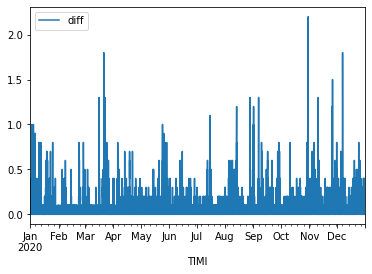

In [5]:
df_rain = pd.read_csv(URL_2020_rain,index_col=0)
df_rain.index = pd.DatetimeIndex(df_rain.index)
df_rain.plot()

# Radar data

In [6]:

URL_tensors = glob(DIR_data + '??.npy')
URL_dates = glob(DIR_data + '??_file_dates.npy')
URL_missing_indexes = glob(DIR_data + '??_missing_indexes.npy')

In [7]:
def get_and_ravel_tensor(URL):
    tensor = np.load(URL)
    return tensor.reshape(-1,np.product(tensor.shape[1:]))

def get_dates(URL):
    dates = np.load(URL,allow_pickle=True)
    return dates

def get_missing(URL):
    missing_indexes = np.load(URL)
    return missing_indexes

def polar_plot(tensor,ax):
    rad_values = np.linspace(0,2*np.pi,420)
    theta_values = np.linspace(0,120,120)
    
    theta,rad = np.meshgrid(rad_values,theta_values)
    ax.pcolormesh(theta, rad, tensor.T, shading='auto')
    
    return ax
    
def plot_slice(tensor):
    f,axes = plt.subplots(2,4,figsize=(12,6),  subplot_kw={'projection': 'polar'})
    for slice_,ax in zip(tensor,axes.ravel()):
        polar_plot(slice_,ax)
    plt.tight_layout()
    plt.show()
        

# Start by looking at just january

In [8]:
# january_tensor = get_and_ravel_tensor(URL_tensors[0])
# january_dates = get_dates(URL_dates[0])
# january_missing = get_missing(URL_missing_indexes[0])

# # Create X and Y to use for comparison
# january_include = np.delete(np.arange(len(january_dates)),january_missing )

# y = df_rain.loc[january_dates[january_include]].values

# #######
# january_correlation = np.zeros(january_tensor.shape[-1])
# for i,pixel in enumerate(january_tensor.T):
#     x_tmp = january_tensor[:,[i]].ravel()
#     if all(x_tmp == 0):
#         january_correlation[i] = 0
#     else:
#         corr = np.corrcoef(y.ravel(),x_tmp)[0,1]
#         january_correlation[i] = corr

# #######

# correlation_tensor = january_correlation.reshape((8, 420, 120))
# sum_tensor = january_tensor.sum(axis=0).reshape((8, 420, 120))
# var_tensor = january_tensor.var(axis=0).reshape((8, 420, 120))

In [9]:
# plot_slice(var_tensor)
# plot_slice(sum_tensor)
# plot_slice(correlation_tensor)

In [10]:
# plot_slice(correlation_tensor)

In [11]:
# plt.plot(january_correlation[january_correlation!=-1])

# Looking at all the months at once

In [12]:

month_lengths = [8918,8327,8922,8523,8880,8632,8916,8928,8606,8840,8603,8872]
n_radar = np.sum(month_lengths)

In [13]:
from scipy.sparse import coo_matrix



sparse_tensor_list = []
for i in range(0,12):
    print(i)
    month_tensor = get_and_ravel_tensor(URL_tensors[i])
    sparse_tensor_list.append(coo_matrix(month_tensor))



0
1
2
3
4
5
6
7
8
9
10
11


In [17]:


sparse_tensor_list[-1].size/month_tensor.size

0.0702720537324488

In [27]:
from scipy.sparse import vstack, save_npz


In [ ]:
sparse_tensor = vstack(sparse_tensor_list)

In [28]:
save_npz(DIR_data + 'radar_2020_sparse_matrix.npz',sparse_tensor)

In [ ]:
sparse_tensor_list[0].__sizeof__()

In [ ]:
np.sum([i.size])

In [17]:
tensor = np.zeros((int(n_radar),403200),dtype='int8')
x_dict = {}
y_dict = {}
for i in range(0,12):
    print(i)
    month_tensor = get_and_ravel_tensor(URL_tensors[i])
    month_dates = get_dates(URL_dates[i])
    month_missing = get_missing(URL_missing_indexes[i])

    # Create X and Y to use for comparison
    month_include = np.delete(np.arange(len(month_dates)),month_missing )
    
    y = df_rain.loc[month_dates[month_include]].values
    start = np.sum(month_lengths[:i])
    end   = np.sum(month_lengths[:i+1])
    tensor[int(start):int(end)] = month_tensor
    
    # tensor_list.append(month_tensor)
    x_dict[i] = {'dates':month_dates,'missing':month_missing}
    y_dict[i] = y

y = np.concatenate([y_dict[i] for i in y_dict])

0
1
2
3
4
5
6
7
8
9
10
11


In [ ]:
# t0 = datetime.datetime.now()
# tensor_correlation = np.zeros(tensor.shape[-1])

# for i,pixel in enumerate(tensor.T):
#     x_tmp = tensor[:,[i]].ravel()
#     tensor_correlation[i] = np.corrcoef(x_tmp.ravel(),y.ravel())[0,1]
#     if i%500 == 0:
#         print(i)
# print(datetime.datetime.now() - t0)

# np.save('correlations',tensor_correlation)

tensor_correlation = np.load('correlations.npy')

In [ ]:
correlation_tensor = tensor_correlation.reshape((8,420,120))

# Correlation as a function of distance

In [1]:
from pyproj import Transformer

transformer_gps_isl = Transformer.from_crs("epsg:4326", "epsg:3057" ) # Umbreyta GPS staðsetningu yfir í cartesian hnit fyrir Ísland
transformer_isl_gps = Transformer.from_crs("epsg:3057", "epsg:4326") # Umbreyta cartesian hnitum aftur í GPS hnit

lat,lon,alt = radar_coordinates = (64.026383, -22.635833, 47)
radar_shape = (8, 420, 120)

distance = 240 # maximum range of radar (in Km)
angles = [0.5, 1.3, 2.4, 5.0, 7.0, 10.0, 15.0, 20.0] # Angle with surface
rotations = np.linspace(0,360,420)
distances = np.linspace(0,240,120)

# Distance from radar to reykjavik
rad_rvk_dist = 40

coordinates = np.zeros((8,420,120,3),dtype = float)
coordinates_isl = np.zeros((8,420,120,3),dtype = float)
isl_hnit = np.array(transformer_gps_isl.transform(lat,lon))


for i,ang in enumerate(angles):
    for j,rot in enumerate(rotations):
        for k,dist in enumerate(distances):
            # print(i,j,k)
            height = np.sin(ang*np.pi/180) * dist * 1000 + alt # Height in meters (Given straight line and flat earth)

            horizontal_offset = np.cos(ang*np.pi/180) * dist * 1000 # Distance in meters (Given straight line and flat earth)
            
            # Offset hnita í íslenska hnitakerfinu (ATH prófa að svissa sin og cos) ############################################################################################################################
            x_offset = np.cos(rot*np.pi/180) * horizontal_offset
            y_offset = np.sin(rot*np.pi/180) * horizontal_offset
            new_x = isl_hnit[0] + x_offset
            new_y = isl_hnit[1] + y_offset
            
            (new_x_gps,new_y_gps) = transformer_isl_gps.transform(new_x,new_y)

            coordinates[i,j,k,:] = np.array([new_x_gps,new_y_gps,height])
            coordinates_isl[i,j,k,:] = np.array([new_x,new_y,height])


ModuleNotFoundError: ignored

In [ ]:
# Comparable to :
# M. Rico-Ramirez, S. Liguori, A. Schellart
# Journal of Hydrology
# (2015)

pixel_coords = coordinates_isl[0].reshape(-1,3)
pixel_corr = correlation_tensor[0].reshape(-1,1)
# max_corr_pixel_idx = np.argmax(pixel_corr)
max_corr_pixel_idx = 9141 
max_corr_pixel_coords = pixel_coords[max_corr_pixel_idx]
distance = np.sqrt(np.sum((pixel_coords - max_corr_pixel_coords)**2,axis=1))

plt.scatter(distance/1000,pixel_corr,s = 0.1)
plt.xlabel('distance [km]')
plt.ylabel('correlation r')
plt.title('Radar 2020')

In [ ]:
correlation_tensor[0].shape

In [ ]:
np.argsort(correlation_tensor[0].ravel())

In [ ]:
np.argmax(correlation_tensor)

In [ ]:
np.argsort(correlation_tensor[0].ravel())[::-1][10]

In [ ]:


plt.figure(figsize=(12,5))
plt.imshow(correlation_tensor[0].T)
for i in np.argsort(correlation_tensor[0].ravel())[::-1][:100]:
    print(i,':',correlation_tensor[0].ravel()[i])
    a,b,c = np.unravel_index(i, correlation_tensor.shape)
    plt.scatter(b,c)


In [ ]:
np.argmax(tensor_correlation)

In [ ]:
tensor_correlation[np.isnan(tensor_correlation)] = 0

In [ ]:
correlation_tensor.shape

In [ ]:
tensor_correlation.argmax()

In [ ]:
tensor_correlation.argsort()

In [ ]:
plt.plot(tensor_correlation[tensor_correlation.argsort()])

In [ ]:
tensor_correlation.shape

In [ ]:
# tensor = np.r_[tensor,y]

In [ ]:
plt.plot(tensor_correlation)

In [ ]:
tensor_correlation

In [ ]:
# tensor.shape

In [ ]:
correlation_tensor = tensor_correlation.reshape((8, 420, 120))
sum_tensor = tensor.sum(axis=0).reshape((8, 420, 120))

In [ ]:
plot_slice(correlation_tensor)
plot_slice(sum_tensor)

In [ ]:
fig, ax = plt.subplots(1,1, subplot_kw={'projection': 'polar'}, figsize=(12,12))
polar_plot(correlation_tensor[0],ax )
plt.show()

In [ ]:
correlation_tensor.shape

In [ ]:
r = np.linspace(0, 120, 120)
p = np.linspace(0, 2*np.pi, 420)
R, P = np.meshgrid(r, p)


# Express the mesh in the cartesian system.
X, Y = R*np.cos(P), R*np.sin(P)


In [ ]:
# rad_values = np.linspace(0,2*np.pi,420)
# theta_values = np.linspace(0,120,120)

# theta,rad = np.meshgrid(rad_values,theta_values)
# X,Y = theta,rad
Z = correlation_tensor[0]
Z[np.isnan(Z)] = 0

In [ ]:
from mpl_toolkits import mplot3d


In [ ]:
# %matplotlib widget
# %matplotlib inline
# %matplotlib notebook
%matplotlib qt

In [ ]:
import PyQt5

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d',)


# Express the mesh in the cartesian system.
# X, Y = R*np.cos(P), R*np.sin(P)

# Plot the surface.
ax.plot_surface(X, Y, Z, cmap=plt.cm.YlGnBu_r)
# ax.plot_surface(X, Y, Z, cmap='seismic')

# Tweak the limits and add latex math labels.
ax.set_zlim(0, 1)
# ax.set_xlabel(r'$\phi_\mathrm{real}$')
# ax.set_ylabel(r'$\phi_\mathrm{im}$')
# ax.set_zlabel(r'$V(\phi)$')

plt.show()

In [ ]:
# plt.imshow(correlation_tensor[0].T)